<a href="https://colab.research.google.com/github/parmidamardi/CDM-MatrixMonitor-FP/blob/main/CDM%E2%80%91MatrixMonitor%E2%80%91FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install pandas numpy matplotlib seaborn openpyxl mlxtend


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import ssl, certifi
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth
import time

In [4]:
# url = "https://raw.githubusercontent.com/parmidamardi/CDM-MatrixMonitor-FP/main/Online%20Retail.xlsx"
# df_2 = pd.read_excel(url, engine='openpyxl')
# print(df_2.columns)

In [5]:
df = pd.read_csv("https://archive.ics.uci.edu/static/public/352/data.csv", encoding='unicode_escape')
print(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [6]:

print(df.shape)
print(df.head())

(541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [7]:
print(df.columns.tolist())


['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [8]:
#Drop rows where any key business attribute is missing
df_clean = df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'])


In [9]:
print(df_clean['InvoiceDate'].dtype)

object


In [10]:
#Convert InvoiceDate to datetime type
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

/var/folders/n0/439bn76s15lbf8y11cgpn7qm0000gn/T/ipykernel_17350/1746825974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')


In [11]:
print(df_clean['InvoiceDate'].dtype)

datetime64[ns]


In [12]:
# Filter invalid transactions
df_clean = df_clean[
    (~df_clean['InvoiceNo'].str.startswith('C')) & (df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)
]

In [13]:
#Reset index for clean iteration
df_clean = df_clean.reset_index(drop=True)

In [14]:
#After cleaning
print("Shape:", df_clean.shape)
print("Columns:", df_clean.columns.tolist())
df_clean.info()
df_clean.describe()
print(df.head(5))

Shape: (397884, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053        

In [15]:
basket_df = df_clean[['InvoiceNo', 'StockCode', 'Quantity']].copy()
basket_df = basket_df[basket_df['Quantity'] > 0]
basket_df['Quantity'] = 1

In [16]:
item_matrix = basket_df.pivot_table(
    index='InvoiceNo',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)
item_matrix = (item_matrix > 0).astype(int)
print(item_matrix.shape)
print(item_matrix.head(15))

(18532, 3665)
StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
InvoiceNo                                                                     
536365         0      0      0       0       0       0      0      0      0   
536366         0      0      0       0       0       0      0      0      0   
536367         0      0      0       0       0       0      0      0      0   
536368         0      0      0       0       0       0      0      0      0   
536369         0      0      0       0       0       0      0      0      0   
536370         1      0      0       0       0       0      0      0      0   
536371         0      0      0       0       0       0      0      0      0   
536372         0      0      0       0       0       0      0      0      0   
536373         0      0      0       0       0       0      0      0      0   
536374         0      0      0       0       0       0      0      0      0   
536375         0      0      0       0

In [17]:
print(item_matrix.loc["536365"]["85123A"])

1


In [18]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
df_clean = df_clean.sort_values('InvoiceDate').reset_index(drop=True)

In [19]:
df_clean['InvoiceDay'] = df_clean['InvoiceDate'].dt.date
print(df_clean[['InvoiceNo', 'InvoiceDate', 'InvoiceDay']].head(5))

  InvoiceNo         InvoiceDate  InvoiceDay
0    536365 2010-12-01 08:26:00  2010-12-01
1    536365 2010-12-01 08:26:00  2010-12-01
2    536365 2010-12-01 08:26:00  2010-12-01
3    536365 2010-12-01 08:26:00  2010-12-01
4    536365 2010-12-01 08:26:00  2010-12-01


In [20]:
time_batches = [group for _, group in df_clean.groupby('InvoiceDay')]

print(f"Total time batches: {len(time_batches)}")

for i, batch in enumerate(time_batches[:3]):
    print(f"Batch {i+1}: {batch['InvoiceDay'].iloc[0]}  ->  {len(batch)} invoices")

Total time batches: 305
Batch 1: 2010-12-01  ->  1942 invoices
Batch 2: 2010-12-02  ->  2000 invoices
Batch 3: 2010-12-03  ->  1103 invoices


In [21]:
invoice_order = (
    df_clean[['InvoiceNo', 'InvoiceDay']]
    .drop_duplicates()
    .sort_values('InvoiceDay')
)
ordered_invoices = invoice_order['InvoiceNo'].tolist()
item_matrix = item_matrix.loc[ordered_invoices]

In [22]:
day_to_invoices = {
    d: g['InvoiceNo'].unique().tolist()
    for d, g in df_clean.groupby('InvoiceDay')
}

stream_batches = [item_matrix.loc[day_to_invoices[d]] for d in day_to_invoices]

print(f"Total batches (days): {len(stream_batches)}")
print(f"Example batch shape: {stream_batches[0].shape}")

Total batches (days): 305
Example batch shape: (121, 3665)


In [23]:
def gaussian_random_projection_sketch(A, k=50):
    n, d = A.shape
    R = np.random.normal(0, 1/np.sqrt(k), size=(d, k))
    B = A @ R
    return B

In [24]:
def incremental_pca_sketch(A, k=50):
    A_centered = A - np.mean(A, axis=0)
    U, S, Vt = np.linalg.svd(A_centered, full_matrices=False)
    B = (U[:, :k] * S[:k]) @ Vt[:k, :]
    return B, Vt[:k, :]

In [25]:
def frequent_directions_sketch(A, l=50, B=None):
    if B is None:
        B = np.zeros((0, A.shape[1]))
    B = np.vstack((B, A))
    if B.shape[0] > l:
        U, S, Vt = np.linalg.svd(B, full_matrices=False)
        delta = S[l//2]**2
        S = np.sqrt(np.maximum(S**2 - delta, 0))
        B = np.diag(S) @ Vt
        B = B[:l, :]
    return B

In [26]:
def frobenius_error(A, B):
    try:
        ATA = A @ A.T
        BTB = B @ B.T
        if ATA.shape != BTB.shape:
            ATA = A.T @ A
            BTB = B.T @ B
        return np.linalg.norm(ATA - BTB, 'fro') / np.linalg.norm(ATA, 'fro')
    except ValueError:
        ATA = A.T @ A
        BTB = B.T @ B
        return np.linalg.norm(ATA - BTB, 'fro') / np.linalg.norm(ATA, 'fro')

def variance_retained(A, B):
    return np.linalg.norm(B, 'fro')**2 / np.linalg.norm(A, 'fro')**2

In [27]:
def reconstruction_error(A, B, method=None, components=None):

    if method == 'GRP':
        A_hat = B @ B.T @ A
    elif method == 'IPCA':
        if components is not None:
            A_centered = A - np.mean(A, axis=0)
            A_hat = (A_centered @ components.T) @ components + np.mean(A, axis=0)
        else:
            A_hat = B
    elif method == 'FD':
        A_hat = A @ (B.T @ B)
    else:
        A_hat = B

    return np.linalg.norm(A - A_hat, 'fro') / np.linalg.norm(A, 'fro')

In [28]:
metrics = {
    "batch": [], "algo": [],
    "fro_err": [], "var_ret": [],
    "recon_err": []
}

k = 50
B_fd = None
V_ipca = None

for i, A_batch in enumerate(stream_batches):
    A = A_batch.values

    # --- GRP ---
    B_grp = gaussian_random_projection_sketch(A, k)
    metrics["batch"].append(i)
    metrics["algo"].append("GRP")
    metrics["fro_err"].append(frobenius_error(A, B_grp))
    metrics["var_ret"].append(variance_retained(A, B_grp))
    metrics["recon_err"].append(reconstruction_error(A, B_grp, method='GRP'))

    # --- IPCA ---
    # B_ipca, V_ipca = incremental_pca_sketch(A, k)
    # metrics["batch"].append(i)
    # metrics["algo"].append("IPCA")
    # metrics["fro_err"].append(frobenius_error(A, B_ipca))
    # metrics["var_ret"].append(variance_retained(A, B_ipca))
    # metrics["recon_err"].append(reconstruction_error(A, B_ipca, method='IPCA', components=V_ipca))

    # --- FD ---
    # B_fd = frequent_directions_sketch(A, k, B=B_fd)
    # metrics["batch"].append(i)
    # metrics["algo"].append("FD")
    # metrics["fro_err"].append(frobenius_error(A, B_fd))
    # metrics["var_ret"].append(variance_retained(A, B_fd))
    # metrics["recon_err"].append(reconstruction_error(A, B_fd, method='FD'))

In [29]:
k = 50
B_fd = None
V_ipca = None

for i, A_batch in enumerate(stream_batches):
    A = A_batch.values

    # --- GRP ---
    # B_grp = gaussian_random_projection_sketch(A, k)
    # metrics["batch"].append(i)
    # metrics["algo"].append("GRP")
    # metrics["fro_err"].append(frobenius_error(A, B_grp))
    # metrics["var_ret"].append(variance_retained(A, B_grp))
    # metrics["recon_err"].append(reconstruction_error(A, B_grp, method='GRP'))

    # --- IPCA ---
    B_ipca, V_ipca = incremental_pca_sketch(A, k)
    metrics["batch"].append(i)
    metrics["algo"].append("IPCA")
    metrics["fro_err"].append(frobenius_error(A, B_ipca))
    metrics["var_ret"].append(variance_retained(A, B_ipca))
    metrics["recon_err"].append(reconstruction_error(A, B_ipca, method='IPCA', components=V_ipca))

    # # --- FD ---
    # B_fd = frequent_directions_sketch(A, k, B=B_fd)
    # metrics["batch"].append(i)
    # metrics["algo"].append("FD")
    # metrics["fro_err"].append(frobenius_error(A, B_fd))
    # metrics["var_ret"].append(variance_retained(A, B_fd))
    # metrics["recon_err"].append(reconstruction_error(A, B_fd, method='FD'))

In [30]:
k = 50
B_fd = None
V_ipca = None

for i, A_batch in enumerate(stream_batches):
    A = A_batch.values

    # --- GRP ---
    # B_grp = gaussian_random_projection_sketch(A, k)
    # metrics["batch"].append(i)
    # metrics["algo"].append("GRP")
    # metrics["fro_err"].append(frobenius_error(A, B_grp))
    # metrics["var_ret"].append(variance_retained(A, B_grp))
    # metrics["recon_err"].append(reconstruction_error(A, B_grp, method='GRP'))

    # --- IPCA ---
    # B_ipca, V_ipca = incremental_pca_sketch(A, k)
    # metrics["batch"].append(i)
    # metrics["algo"].append("IPCA")
    # metrics["fro_err"].append(frobenius_error(A, B_ipca))
    # metrics["var_ret"].append(variance_retained(A, B_ipca))
    # metrics["recon_err"].append(reconstruction_error(A, B_ipca, method='IPCA', components=V_ipca))

    # # --- FD ---
    B_fd = frequent_directions_sketch(A, k, B=B_fd)
    metrics["batch"].append(i)
    metrics["algo"].append("FD")
    metrics["fro_err"].append(frobenius_error(A, B_fd))
    metrics["var_ret"].append(variance_retained(A, B_fd))
    metrics["recon_err"].append(reconstruction_error(A, B_fd, method='FD'))

In [31]:
df_metrics = pd.DataFrame(metrics)
display(df_metrics.head(20))

,batch,algo,fro_err,var_ret,recon_err
0,0,GRP,0.917486,0.975873,61.276489
1,1,GRP,0.877352,0.973562,74.572122
2,2,GRP,0.722226,0.964630,51.487207
3,3,GRP,0.896007,1.013978,108.464917
4,4,GRP,0.881239,0.970428,68.377543
5,5,GRP,0.776731,0.972733,41.755603
6,6,GRP,0.910541,1.029492,81.129872
7,7,GRP,0.919758,0.964273,56.616559
8,8,GRP,0.773396,0.951218,57.481246
9,9,GRP,0.643614,0.971490,80.324777


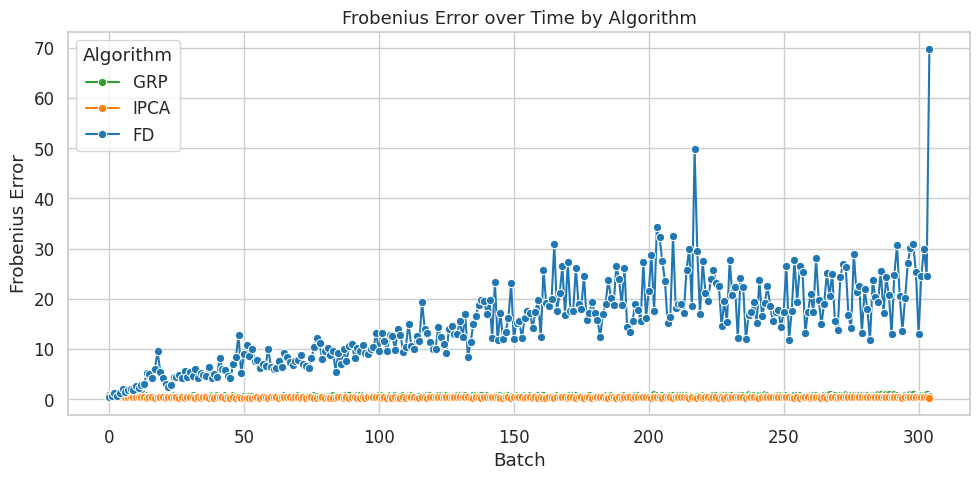

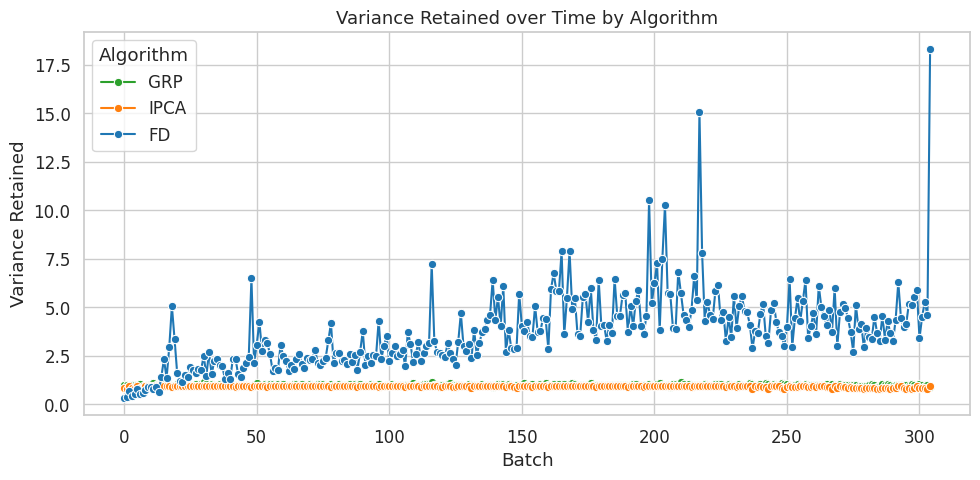

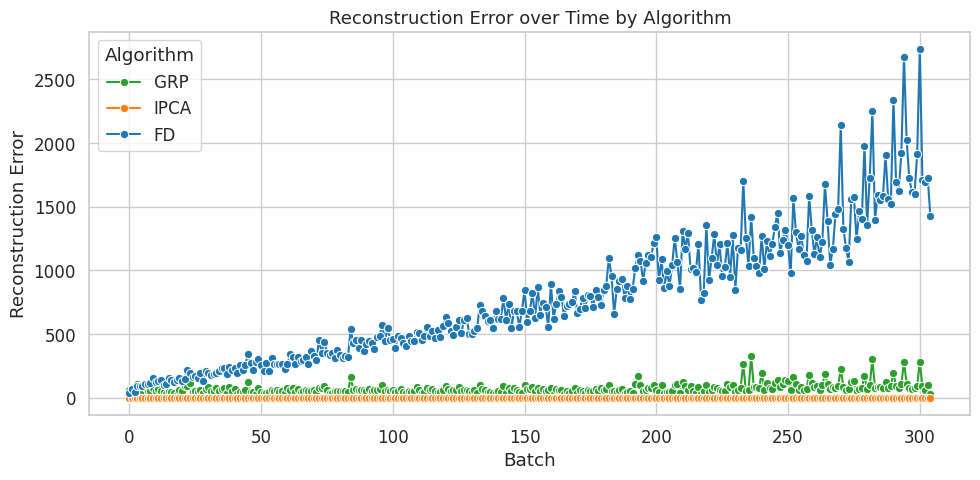

In [32]:
sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.1)

metrics = ['fro_err', 'var_ret', 'recon_err']
titles = ['Frobenius Error', 'Variance Retained', 'Reconstruction Error']

palette = {
    'FD': '#1f77b4',
    'IPCA': '#ff7f0e',
    'GRP': '#2ca02c'
}

for m, t in zip(metrics, titles):
    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=df_metrics,
        x='batch',
        y=m,
        hue='algo',
        marker='o',
        palette=palette
    )
    plt.title(f'{t} over Time by Algorithm', fontsize=13)
    plt.xlabel('Batch')
    plt.ylabel(t)
    plt.legend(title='Algorithm')
    plt.tight_layout()
    plt.show()

In [33]:
def mine_patterns(matrix, min_support=0.05, method='fpgrowth', sample_ratio=0.1, min_item_freq=0.01):
    start = time.time()

    if isinstance(matrix, np.ndarray):
        df_bin = pd.DataFrame(matrix)
    else:
        df_bin = matrix.copy()

    if df_bin.values.max() > 1:
        df_bin = (df_bin > 0).astype(np.uint8)

    min_occ = int(df_bin.shape[0] * min_item_freq)
    df_bin = df_bin.loc[:, df_bin.sum(axis=0) > min_occ]

    if df_bin.shape[0] > 20000:
        df_bin = df_bin.sample(frac=sample_ratio, random_state=42)

    if method == 'apriori':
        results = apriori(df_bin, min_support=min_support, use_colnames=True)
    else:
        results = fpgrowth(df_bin, min_support=min_support, use_colnames=True)

    elapsed = time.time() - start
    return results, elapsed


def compare_patterns(A, compressed_list, names, min_support=0.05, method='fpgrowth'):
    base_patterns, base_time = mine_patterns(A, min_support, method)
    base_sets = set(map(frozenset, base_patterns['itemsets']))
    print(f"Original matrix → {len(base_sets)} pattern(s)  ⏱ {base_time:.2f}s")

    summary = []

    for B, name in zip(compressed_list, names):
        patterns, elapsed = mine_patterns(B, min_support, method)
        sets = set(map(frozenset, patterns['itemsets']))
        overlap = len(sets & base_sets) / (len(sets | base_sets) + 1e-9)
        summary.append({
            'matrix': name,
            'patterns_found': len(sets),
            'speed_sec': round(elapsed, 3),
            'similarity_to_original': round(overlap, 3)
        })
        print(f"{name:<5} → {len(sets)} patterns  ⏱ {elapsed:.2f}s  |  similarity={overlap:.3f}")

    return pd.DataFrame(summary)


In [34]:
A = item_matrix.values
k = 50
min_support = 0.02
method = 'fpgrowth'

def run_and_show(name, B_list):
    print(f"\n⚙️ Running Frequent Pattern Mining for {name} ...")
    df_res = compare_patterns(
        A,
        B_list,
        [name],
        min_support=min_support,
        method=method
    )
    print(f"✅ {name} completed.\n")
    display(df_res.head(10))
    print("-" * 80)
    return df_res

In [35]:
B_grp = gaussian_random_projection_sketch(A, k=k)
df_grp = run_and_show("GRP", [B_grp])

In [36]:
B_ipca, V_ipca = incremental_pca_sketch(A, k=k)
df_ipca = run_and_show("IPCA", [B_ipca])

In [37]:
# B_fd = frequent_directions_sketch(A, l=k)
# df_fd = run_and_show("FD", [B_fd])

In [38]:
# result_df = pd.concat([df_grp or [], df_ipca or [], df_fd or []], ignore_index=True)
# print("\n📊 All algorithms completed successfully! Combined results:")
# display(result_df.head(20))

Injected artificial anomalies in batches [5, 12, 20]
305


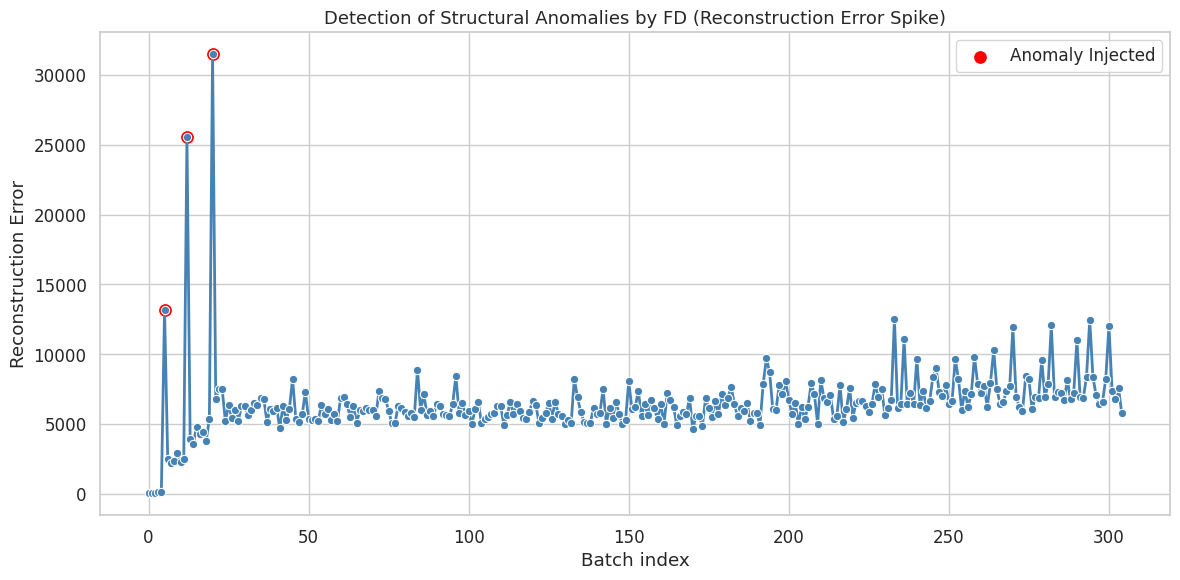

📊 Average reconstruction error (normal): 6303.1107
📊 Average reconstruction error (anomalous batches): 23397.5525
Δ relative increase: 271.2%


In [39]:

stream_batches_anom = []
anom_indices = [5, 12, 20]

for idx, batch in enumerate(stream_batches):
    A = batch.copy()
    if idx in anom_indices:
        mod = A.copy()
        anomaly_noise = np.random.binomial(1, 0.3, size=mod.shape)
        mod = (mod + anomaly_noise) % 2
        stream_batches_anom.append(mod)
    else:
        stream_batches_anom.append(A)

print(f"Injected artificial anomalies in batches {anom_indices}")

metrics_anom = {
    "batch": [], "algo": [],
    "fro_err": [], "var_ret": [],
    "recon_err": [], "is_anomaly": []
}

k = 50
B_fd, V_ipca = None, None


print(len(stream_batches_anom))

for i, A_batch in enumerate(stream_batches_anom):
    A = A_batch.values
    
    B_fd = frequent_directions_sketch(A, k, B=B_fd)
    metrics_anom["batch"].append(i)
    metrics_anom["algo"].append("FD")
    metrics_anom["fro_err"].append(frobenius_error(A, B_fd))
    metrics_anom["var_ret"].append(variance_retained(A, B_fd))
    metrics_anom["recon_err"].append(reconstruction_error(A, B_fd, method='FD'))
    metrics_anom["is_anomaly"].append(1 if i in anom_indices else 0)

df_anom = pd.DataFrame(metrics_anom)

sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.1)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_anom, x='batch', y='recon_err', marker='o', color='steelblue', linewidth=2)
sns.scatterplot(data=df_anom[df_anom['is_anomaly'] == 1],
                x='batch', y='recon_err', color='red', s=100, label='Anomaly Injected')
plt.title('Detection of Structural Anomalies by FD (Reconstruction Error Spike)', fontsize=13)
plt.xlabel('Batch index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

avg_normal = df_anom[df_anom['is_anomaly'] == 0]['recon_err'].mean()
avg_anom   = df_anom[df_anom['is_anomaly'] == 1]['recon_err'].mean()
print(f"📊 Average reconstruction error (normal): {avg_normal:.4f}")
print(f"📊 Average reconstruction error (anomalous batches): {avg_anom:.4f}")
print(f"Δ relative increase: {(avg_anom - avg_normal)/avg_normal*100:.1f}%")
